# The Spatial Module

So far, we have trained, tested, and run the temporal module, which is here: https://colab.research.google.com/drive/1NnGjT80qrxxq4teM7m2gvs80TkwNXMjs?usp=sharing

In [ ]:
!git clone https://github.com/rdemedrano/crann_traffic.git
%cd crann_traffic/
%cd Spatial\ module
!pip install configargparse

Cloning into 'crann_traffic'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 224 (delta 60), reused 198 (delta 45), pack-reused 0
Receiving objects: 100% (224/224), 30.09 MiB | 24.59 MiB/s, done.
Resolving deltas: 100% (60/60), done.
/content/crann_traffic
/content/crann_traffic/Spatial module


In [ ]:
import os
import json
import numpy as np

import torch

from dataset import data_transform
from utils import DotDict, Logger, bias, denormalize_data, rel_error, rmse
from sp_att_mech import AttentionCNN

import matplotlib.pyplot as plt
%matplotlib inline

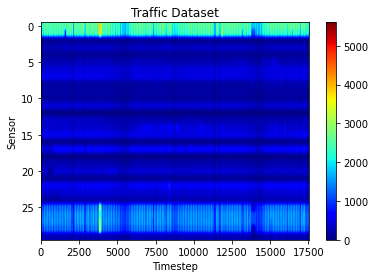

In [ ]:
datadir = 'data'
dataset = 'sp_data.csv'
data = torch.Tensor(np.genfromtxt(os.path.join('..',datadir, dataset)))

plt.figure('Traffic Dataset')
plt.imshow(data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('Traffic Dataset')
plt.xlabel('Timestep')
plt.ylabel('Sensor')
plt.colorbar()

Run the training file to train the spatial submodel (CNN based architecture with attention mechanism) for 200 epochs. Usually, even with GPU, each submodel approximately takes 100 minutes to train.

In [ ]:
run training.py

 51%|█████     | 102/200 [01:31<01:27,  1.12it/s, lr=0.0001, train_mse=0.00847, train_rmse=0.092, val_mse=0.00836, val_rmse=0.0914]



 *  Test MSE:  58546.69921875 
 *  Test RMSE:  241.96425194385637 
 *  Test Bias:  -22.783523559570312 
 *  Test Rel-Err (%):  21.7390775680542



<Figure size 432x288 with 0 Axes>

Results

In [ ]:
outputdir  = opt.outputdir
with open(os.path.join(outputdir, 'logs.json'), 'r') as f:
    logs = json.load(f)
    
with open(os.path.join(outputdir, 'config.json'), 'r') as f:
    config = json.load(f)

opt = DotDict(config)

In [ ]:
model = AttentionCNN(in_channels=opt.n_inp, out_channels=opt.n_out, 
                     dim_x=opt.dim_x, dim_y=opt.dim_y)
model.to(device)
model.load_state_dict(torch.load(os.path.join(outputdir, 'spatial_model.pth')))

<All keys matched successfully>

In [ ]:
_, _, _, _, X_test, Y_test, min_value, max_value = data_transform(opt)

test_dataset = []
for i in range(len(X_test)):
   test_dataset.append([X_test[i], Y_test[i]]) 
    
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = len(X_test),
                                           shuffle = False)

In [ ]:
model.eval()
with torch.no_grad():        
    for x,y in test_loader:
        if torch.cuda.is_available():
            x = x.to(device)
            y = y.to(device)
        else:
            x = x
            y = y
        y_pred, _ = model(x)
        
        y_pred_dnorm = denormalize_data(y_pred.view(-1, opt.n_inp, opt.n_points).cpu(), min_value, max_value)
        y_dnorm = denormalize_data(y.view(-1, opt.n_inp, opt.n_points).cpu(), min_value, max_value)

y_tstep = y_dnorm[16::24]
y_pred_tstep = y_pred_dnorm[16::24]

Example of the autoencoding/prediction process:

Text(0.5, 1.0, 'Absolute error')

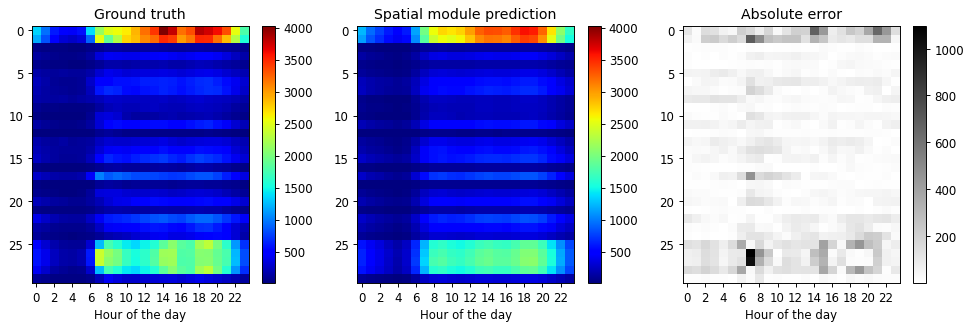

In [ ]:
real = y_tstep.mean(0)
prediction = y_pred_tstep.mean(0)

plt.figure('Example', figsize=(14, 4), dpi=85)

plt.subplot(1, 3, 1)
plt.imshow(real.T,  vmin = real.min(), vmax = real.max(), aspect='auto', cmap='jet')
plt.xticks(np.arange(0, 24, 2))
#plt.yticks(np.arange(0, 30, 1))
plt.xlabel('Hour of the day')
plt.colorbar()
plt.title('Ground truth')

plt.subplot(1, 3, 2)
plt.imshow(prediction.T,  vmin = real.min(), vmax = real.max(), aspect='auto', cmap='jet')
plt.xticks(np.arange(0, 24, 2))
#plt.yticks(np.arange(0, 30, 1))
plt.xlabel('Hour of the day')
plt.colorbar()
plt.title('Spatial module prediction')

plt.subplot(1, 3, 3)
plt.imshow(real.sub(prediction).abs().T, aspect='auto', cmap='gray_r')
plt.xticks(np.arange(0, 24, 2))
#plt.yticks(np.arange(0, 30, 1))
plt.xlabel('Hour of the day')
plt.colorbar()
plt.title('Absolute error')

Learning courve

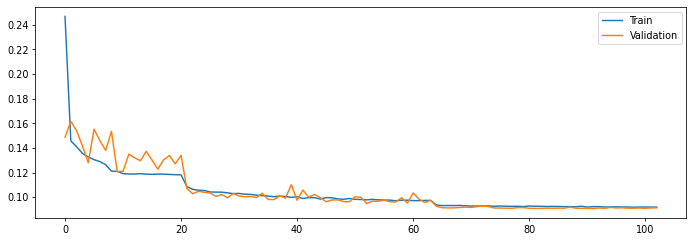

In [ ]:
plt.figure('Error', figsize=(12, 4), dpi=70)
plt.plot(np.sqrt(logs['train.mse']), label = 'Train')
plt.plot(np.sqrt(logs['val.mse']), label = 'Validation')
plt.legend()

Temporal RMSE distribution: hour

Text(0.5, 0, 'Hour of the day')

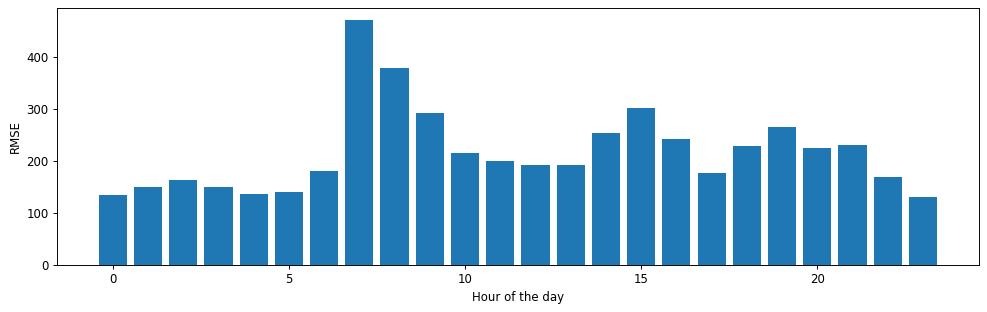

In [ ]:
plt.figure('RMSE dist hour', figsize=(14, 4), dpi=85)
plt.bar(x = range(0,24),height = rmse(y_pred_tstep,y_tstep, dim=2))
plt.ylabel('RMSE')
plt.xlabel('Hour of the day')


Temporal RMSE distribution: timestep

Text(0.5, 0, 'Timestep')

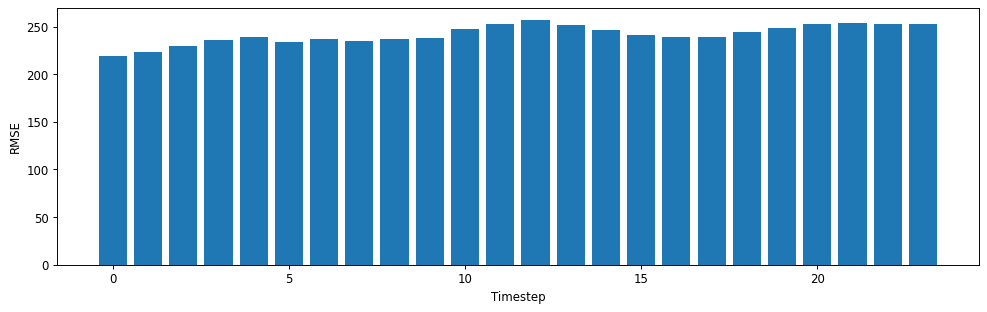

In [ ]:
plt.figure('RMSE dist timestep', figsize=(14, 4), dpi=85)
plt.bar(x = range(0,24),height = rmse(y_pred_dnorm, y_dnorm, dim=2))
plt.ylabel('RMSE')
plt.xlabel('Timestep')


Spatial RMSE distribution

Text(0.5, 0, 'Sensor')

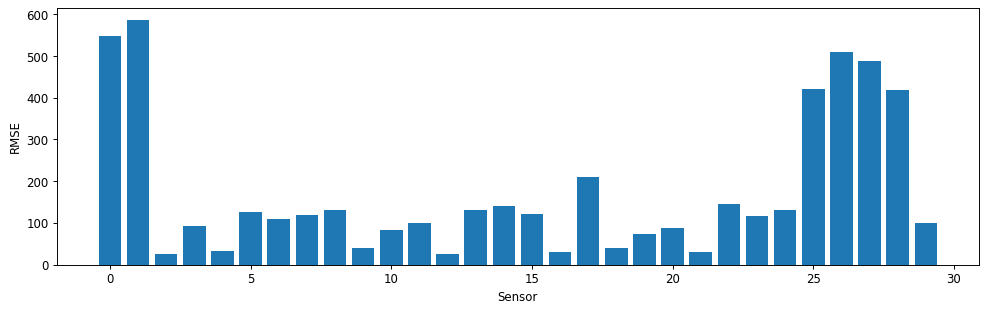

In [ ]:
plt.figure('RMSE dist spatial', figsize=(14, 4), dpi=85)
plt.bar(x = np.arange(0,30),height = rmse(y_pred_dnorm,y_dnorm, dim=1))
plt.ylabel('RMSE')
plt.xlabel('Sensor')

# The Dense Module

Once we move on to the next module, we need to re-index our directory in the shell, by rewinding one folder (cd -), then appending 'cd' with "Spatial Module". In this case, the directory has already been cleared by the '%reset -f' shell command.

In [ ]:
%reset -f
import os
os.chdir("/content/crann_traffic/Dense module")

Proceed to the next worksheet to continue to the dense module: https://colab.research.google.com/drive/1BPraySSp7ymHibXc90oa3QuevrqMRop9?usp=sharing